# Imports

In [111]:
import os
import time
import numpy as np
from dotenv import load_dotenv
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
from spotipy import Spotify
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

# ETL

## Definiciones 

In [66]:
def get_playlist_info(playlist: dict, genre: str):
    '''Create dict merging playlist ID and genre'''
    return {
        "id": playlist["id"],
        "genre": genre 
    }


def get_track_info(track,genre):
    '''Create dict merging track info and genre'''
    return {
        "id": track["id"],
        "name": track["name"],
        "album_id": track["album"]["id"],
        "genre":genre
    }


def get_tracks_from_playlists(playlists: pd.DataFrame, sp: Spotify,verbose:bool=False,remove_nulls:bool=True):
    '''Create a DataFrame containing track info'''
    tracks_playlists = []
    errors = []

    for idx, playlist_id in enumerate(tqdm(playlists["id"])):
        try:
            playlist_tracks = sp.playlist_tracks(playlist_id=playlist_id)
            tracks_playlist = [get_track_info(item["track"],playlists["genre"][idx]) for item in playlist_tracks["items"]]
            tracks_playlists += tracks_playlist
        except TypeError as err:
            # print(f"Error en fila {idx}", err)
            errors.append(f"Error en fila {idx}, {err}")
            continue
    if verbose:
        print('Errors: ', errors)

    df_tracks = pd.DataFrame(tracks_playlists)

    # Validation of tracks with null values
    if verbose:
        print('Null in id col of tracks:', df_tracks["id"].isna().value_counts())

    # Delete rows with null values
    if remove_nulls:
        df_tracks.dropna(inplace=True)
    
    
    return df_tracks

def get_playlists_from_list(seeds:list,limit:int,verbose:bool=False,remove_nulls:bool=True):
    '''Generates a DataFrame, each row is one of <limit> playlists for each genre in seeds'''
    playlists = []
    for genre in seeds:
        # Search playlists by genre
        if verbose:
            print('➡️', end='')
        
        playlists_data = sp.search(q=genre, type='playlist', limit=limit, offset=0)
        playlists += [
            get_playlist_info(playlist, genre)
            for playlist in playlists_data['playlists']['items']
        ]
    df_playlists = pd.DataFrame(playlists)
    # Validation of playlists with null values
    if verbose:
        print(f'Null in id col of playlists', df_playlists["id"].isna().value_counts())
    # Delete rows with null values
    if remove_nulls:
        df_playlists.dropna(inplace=True)
    
    return df_playlists

def clear_duplicates(df_tracks:pd.DataFrame, remove:bool=False):
    '''Cleans duplicates from tracks, if remove is True, deleting them; if remove is False, combining their genres into a combined string like example:
        Example: id 4fgJe7zBjVXvs8HxtE21Y9 has 2 genres: 'anime' and 'j-pop'
        We will merge them into one: 'anime,j-pop'
    '''
    if remove:
        df_tracks_clean=df_tracks.drop_duplicates(subset=["id"])
    else:
        df_tracks_clean = df_tracks.groupby(["id", "name", "album_id"])["genre"].apply(lambda x: ','.join(x)).reset_index()
    return df_tracks_clean

def get_audio_features(df_tracks:pd.DataFrame,verbose:bool=False):
    '''From dataframe with track info, get a new dataFrame with audio features for each track'''
    audio_features = []

    for n in tqdm(range(len(df_tracks) // 100 + 1)):
        df_track_pack = df_tracks.iloc[n*100:(n+1)*100]
        audio_features_pack = sp.audio_features(tracks=list(df_track_pack['id']))
        audio_features += audio_features_pack
    #Delete none before converting into DataFrame    
    audio_features = [af for af in audio_features if af is not None]
    df_audio_features = pd.DataFrame(audio_features)

    if verbose:
        idx_af_bads = []
        for idx, af in enumerate(audio_features):
            if af is None:
                idx_af_bads.append(idx)
        print('Number of None values in audio features:', len(idx_af_bads))
    
    df_tracks_audio_features = pd.merge(
        df_tracks,
        df_audio_features,
        on="id",
        how="inner"
    )

    return df_tracks_audio_features

def es_multi_genero(genre):
  return len(set(genre.split(','))) >1 

def contar_multigeneros(songs:pd.DataFrame):
    multi_g = 0 
    for genre in songs.genre:
        if es_multi_genero(genre):
            multi_g += 1
    print(multi_g, str(multi_g/songs.shape[0]*100)+'%')

## Generacion del Dataset

Cargamos las credenciales de la API de spotify

In [32]:
# Spotify API credentials
load_dotenv()
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

# Spotify API authentication
client_credentials_manager = SpotifyClientCredentials(
    client_id='494d1b2d0fa940a58d9c4ce868a2bcb3',
    client_secret='fc927c45ed74477ab8ce4e2f1c490f62'
)
sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

Armamos la lista de generos de los cuales vamos a buscar canciones

In [61]:
#Genre seeds provided by Spotify
genres_seeds = [
    "acoustic", "afrobeat", "alt-rock", "alternative", "ambient", "anime", "black-metal", "bluegrass",
    "blues", "bossanova", "brazil", "breakbeat", "british", "cantopop", "chicago-house", "children", "chill",
    "classical", "club", "comedy", "country", "dance", "dancehall", "death-metal", "deep-house", "detroit-techno",
    "disco", "disney", "drum-and-bass", "dub", "dubstep", "edm", "electro", "electronic", "emo", "folk", "forro",
    "french", "funk", "garage", "german", "gospel", "goth", "grindcore", "groove", "grunge", "guitar", "happy",
    "hard-rock", "hardcore", "hardstyle", "heavy-metal", "hip-hop", "holidays", "honky-tonk", "house", "idm", "indian", 
    "indie", "indie-pop", "industrial", "iranian", "j-dance", "j-idol", "j-pop", "j-rock", "jazz", "k-pop", "kids",
    "latin", "latino", "malay", "mandopop", "metal", "metal-misc", "metalcore", "minimal-techno", "movies", "mpb",
    "new-age", "new-release", "opera", "pagode", "party", "philippines-opm", "piano", "pop", "pop-film", "post-dubstep",
    "power-pop", "progressive-house", "psych-rock", "punk", "punk-rock", "r-n-b", "rainy-day", "reggae", "reggaeton",
    "road-trip", "rock", "rock-n-roll", "rockabilly", "romance", "sad", "salsa", "samba", "sertanejo", "show-tunes",
    "singer-songwriter", "ska", "sleep", "songwriter", "soul", "soundtracks", "spanish", "study", "summer", "swedish",
    "synth-pop", "tango", "techno", "trance", "trip-hop", "turkish", "work-out", "world-music"
]

Generamos el dataset con los audio features que provee spotify

In [ ]:
#Create dataframe with playlists id and genre
df_playlists = get_playlists_from_list(genres_seeds,10)

In [ ]:
# Save df_playlists to csv
df_playlists.to_csv('./datasets/playlists.csv', index=False)

In [22]:
tracks_playlists = get_tracks_from_playlists(playlists=df_playlists, sp=sp)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Errors:  []


In [26]:
tracks_playlists = clear_duplicates(tracks_playlists)

In [ ]:
# Save df_tracks to csv
tracks_playlists.to_csv('./datasets/tracks.csv', index=False)

In [28]:
df_tracks_audio_features = get_audio_features(tracks_playlists)

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


In [ ]:
# Save df_tracks_audio_features to csv
df_tracks_audio_features.to_csv('./datasets/tracks_audio_features.csv', index=False)

In [63]:
df_tracks_audio_features = pd.read_csv('./datasets/tracks_audio_features.csv')

Al principio elegimos muchos generos y nos resulto dificil el analisis, por lo que volvimos para filtrarlos e ir de a poco

In [86]:
genres_selected = [
    "classical", "hip-hop","jazz","pop","rock"
]
tracks_selected = df_tracks_audio_features[df_tracks_audio_features['genre'].isin(genres_selected)]

Hasta aca el dataset puede llegar a contener canciones 'multi-genero' (por como manejamos los casos de IDs duplicados). Nosotros elegimos eliminarlos porque nos complejizan el analisis.

In [89]:
contar_multigeneros(tracks_selected)

0 0.0%


In [90]:
tracks_selected=tracks_selected.drop(tracks_selected[tracks_selected.genre.apply(lambda x: es_multi_genero(x))].index)

Por otro lado, tenemos canciones que, por pertenecer a dos o mas playlists del mismo genero, tienen el genero duplicado, vamos a limpiarlos

In [92]:
tracks_selected['genre'] = tracks_selected.genre.apply(lambda x: ''.join(set(x.split(','))) )

# EDA

In [33]:
tracks_selected.columns

Index(['id', 'name', 'album_id', 'genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [81]:
tracks_selected.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2130 entries, 18 to 67276
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                2130 non-null   object 
 1   name              2130 non-null   object 
 2   album_id          2130 non-null   object 
 3   genre             2130 non-null   object 
 4   danceability      2130 non-null   float64
 5   energy            2130 non-null   float64
 6   key               2130 non-null   int64  
 7   loudness          2130 non-null   float64
 8   mode              2130 non-null   int64  
 9   speechiness       2130 non-null   float64
 10  acousticness      2130 non-null   float64
 11  instrumentalness  2130 non-null   float64
 12  liveness          2130 non-null   float64
 13  valence           2130 non-null   float64
 14  tempo             2130 non-null   float64
 15  type              2130 non-null   object 
 16  uri               2130 non-null   object 
 17

Key, Time Signature y Mode son categoricas segun la Documentacion de Spotify

In [93]:
tracks_selected['key']=tracks_selected.key.apply(lambda x: str(x))
tracks_selected['time_signature']=tracks_selected.time_signature.apply(str)
tracks_selected.drop(tracks_selected[tracks_selected['time_signature']=='0'].index,inplace=True) #son 3 rancias
tracks_selected['mode']=tracks_selected.time_signature.apply(str)

In [83]:
tracks_selected.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2128.000000,2.128000e+03
mean,0.520489,0.383445,-14.798469,0.085228,0.576137,0.434388,0.155525,0.366844,112.120859,2.256868e+05
std,0.195595,0.310701,9.402381,0.093320,0.407669,0.429908,0.124545,0.255506,32.719550,1.034847e+05
min,0.065300,0.000715,-47.903000,0.024800,0.000017,0.000000,0.022500,0.030200,47.362000,5.292900e+04
25%,0.382000,0.073375,-21.949000,0.037300,0.102750,0.000002,0.094700,0.146000,85.314000,1.672908e+05
50%,0.513000,0.335000,-12.184500,0.045450,0.756000,0.322000,0.111000,0.311000,107.217000,2.067615e+05
75%,0.667250,0.670000,-6.665250,0.075775,0.976000,0.901000,0.154000,0.563000,134.075500,2.536048e+05
max,0.967000,0.995000,-0.140000,0.741000,0.996000,0.985000,0.979000,0.974000,234.451000,1.252322e+06


Vemos que duration, tempo y loudness estan en otras escalas, por lo que vamos a normalizarlas

In [94]:
#Normalize duration from milisec to sec
tracks_selected['duration_ms'] = tracks_selected['duration_ms']/60000  

#Normalizo la variable loudness
tracks_selected['loudness'] = tracks_selected['loudness']/60


#normalizo la variable tempo
tracks_selected['tempo'] = tracks_selected['tempo']/100

In [95]:
tracks_selected["genre"].value_counts()

genre
jazz         680
classical    571
hip-hop      408
rock         239
pop          230
Name: count, dtype: int64

Text(0, 0.5, 'Cantidad de géneros')

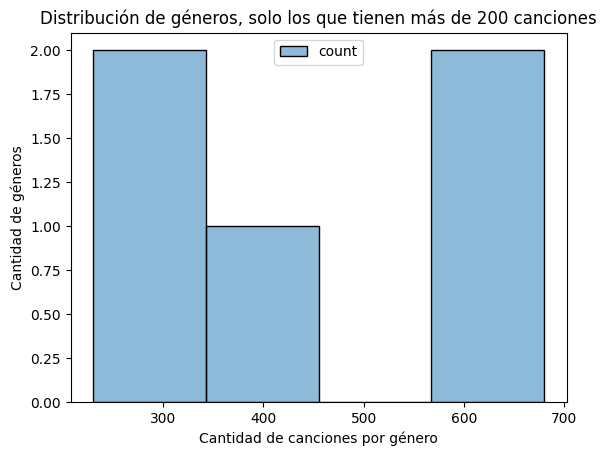

In [96]:
sns.histplot(tracks_selected.genre.value_counts().to_frame())
plt.title('Distribución de géneros, solo los que tienen más de 200 canciones')
plt.xlabel('Cantidad de canciones por género')
plt.ylabel('Cantidad de géneros')

In [ ]:
# save df as 'tracks_audio_features_selected.csv'
tracks_selected.to_csv('./datasets/tracks_audio_features_selected.csv', index=False)

Separamos los features numericos para hacer la matriz de correlacion general

Text(0.5, 1.0, 'Correlation matrix')

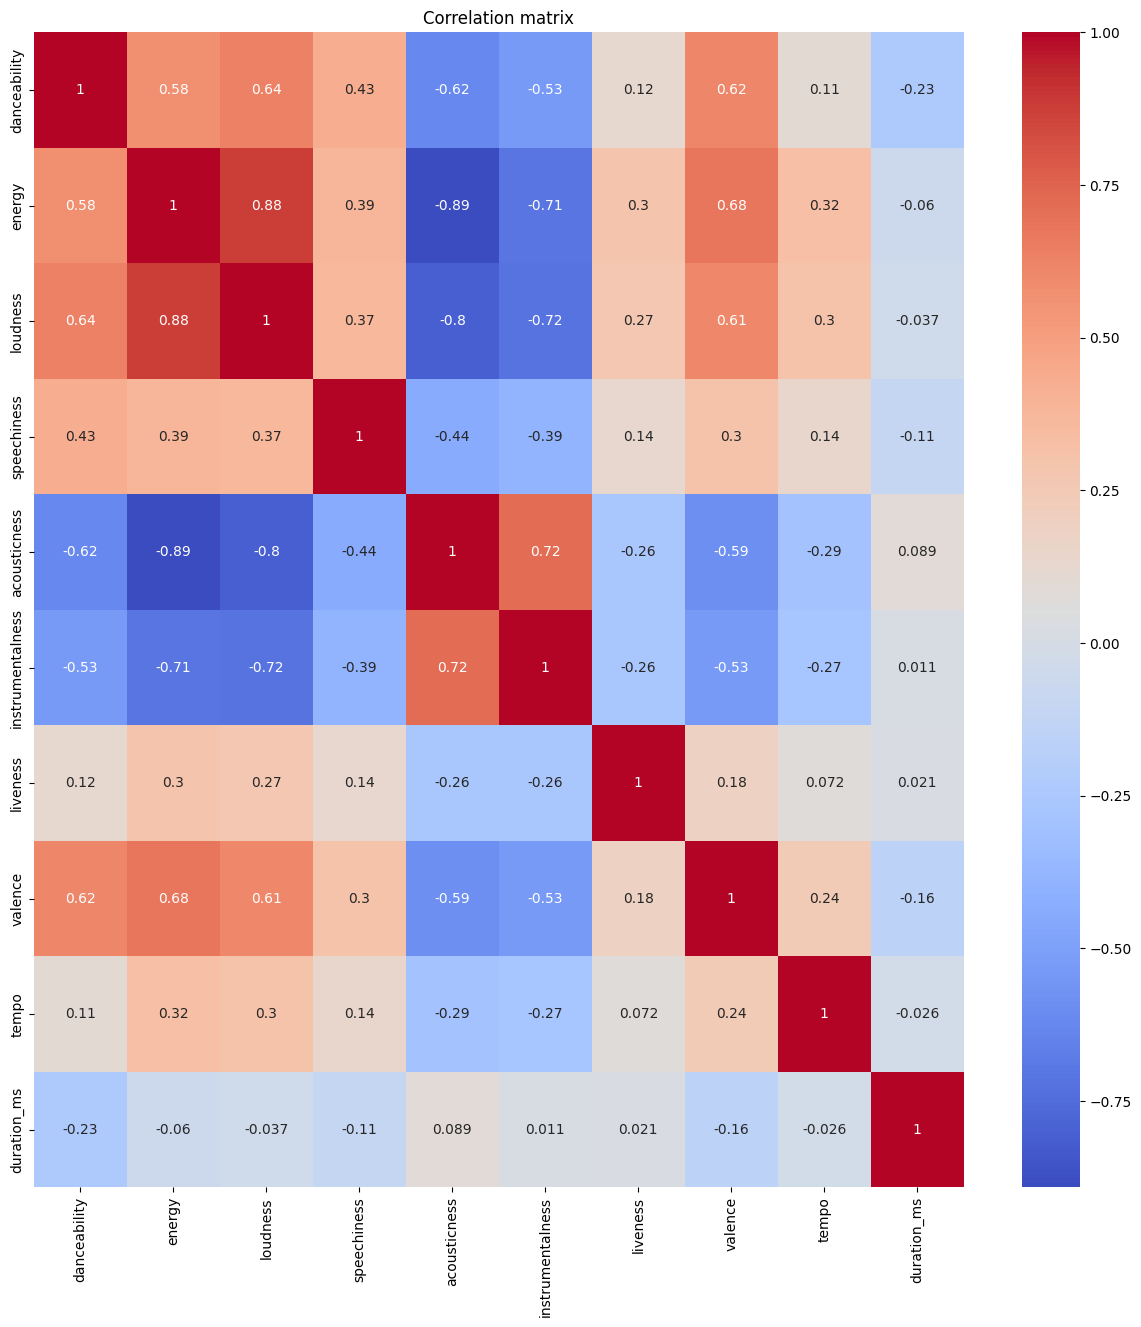

In [97]:
included_types = ['float64', 'int64']
selected_columns = tracks_selected.select_dtypes(include=included_types).columns
selected_variables = tracks_selected[selected_columns]

corr_matrix = selected_variables.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')

Podriamos hacer la matriz de correlacion para cada genero, pero a medida que querramos agregar mas y mas generos, se nos va a hacer imposible analizarlos todos con detenimiento. Por lo que, dada la cantidad de features numericos que tenemos, vamos a realizar una reduccion dimensional para poder visualizar mejor los generos.

## PCA

In [102]:
scaler = StandardScaler()
selected_variables_scaled = scaler.fit_transform(selected_variables)
pca = PCA(n_components=3).fit(selected_variables_scaled)
X_pca =  pca.transform(selected_variables_scaled)

Agregamos colores por generos

In [103]:
colormaping = tracks_selected['genre']

#Coloreo a los componetes de genero
#list_generos =list(colormaping.unique())

#Usemos la lista con la que filtramos los generos! genres_selected
list_generos = genres_selected #lo pongo asi por si pinta volver atras

colors = plt.cm.rainbow(np.linspace(0, 1, len(list_generos)))
tracks_selected['color'] = colormaping.apply(lambda x: colors[list_generos.index(x)])


#Tengo que crear un diccionario de los colores para las leyendas (idk why tiene que un dic)
genre_color_map = {genre: color for genre, color in zip(list_generos, colors)}

C:\Users\admin\AppData\Local\Temp\ipykernel_7120\774826354.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


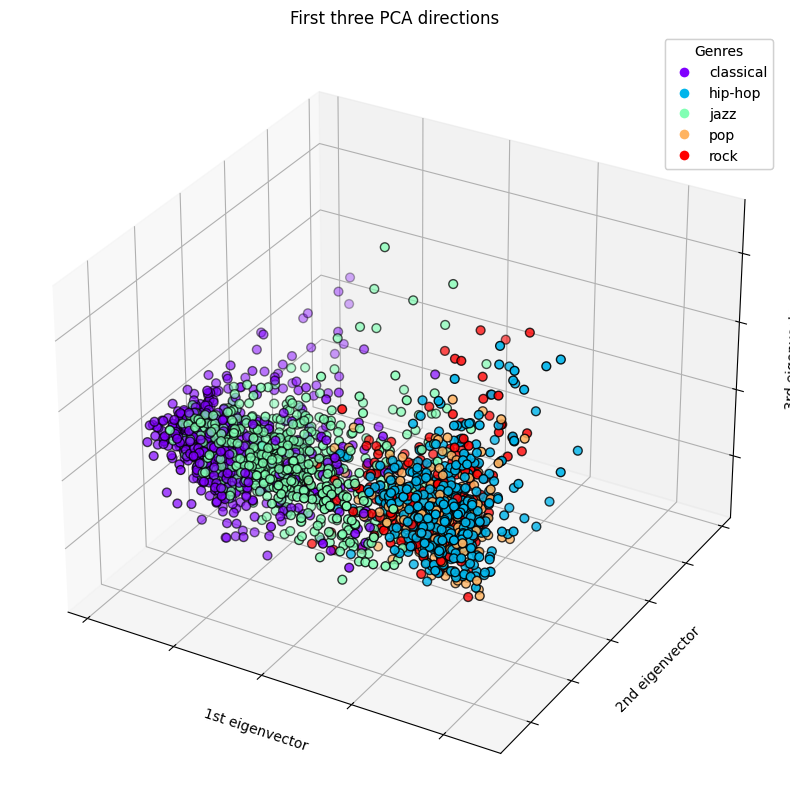

In [104]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

#Grafico
scatter = ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    X_pca[:, 2],
    c=tracks_selected['color'],#Agrego colores
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

#By ChatGPT
#Leyenda
legend_elements = []
for genre, color in genre_color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=genre))


legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)


ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
ax.set_zlabel("3rd eigenvector")
ax.zaxis.set_ticklabels([])
plt.show()

In [105]:
#Ver los primeros elementos de la variancia explicada
print(pca.explained_variance_ratio_[:3]) #3 = n_components

[0.4858382  0.11349149 0.09341805]


Como los pesos de las primeras dos componentes suman el 50% de la varianza y la tercera solo aporta el 9%, grafico las 2 primeras

C:\Users\admin\AppData\Local\Temp\ipykernel_7120\2989196335.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(


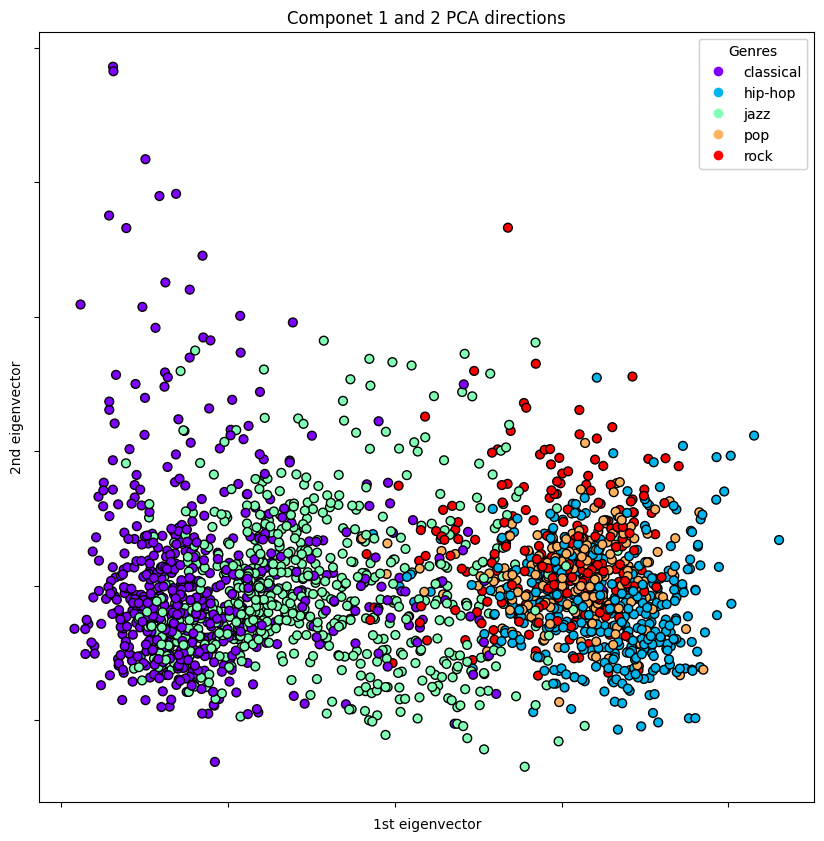

In [106]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)


ax.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    #X_pca[:, 2],
    c=tracks_selected['color'],#Agrego colores
    cmap=plt.cm.Set1,
    edgecolor="k",
    s=40,
)

#Leyenda
legend_elements = []
for genre, color in genre_color_map.items():
    legend_elements.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=genre))


legend1 = ax.legend(handles=legend_elements, loc="upper right", title="Genres")
ax.add_artist(legend1)


ax.set_title("Componet 1 and 2 PCA directions")
ax.set_xlabel("1st eigenvector")
ax.xaxis.set_ticklabels([])
ax.set_ylabel("2nd eigenvector")
ax.yaxis.set_ticklabels([])
plt.show()

In [113]:
pca_testeo = PCA(10).fit(selected_variables_scaled)
X_pca_testeo = pca_testeo.transform(selected_variables_scaled)

Con 8 componentes, preservamos el 0.95 de la varianza.


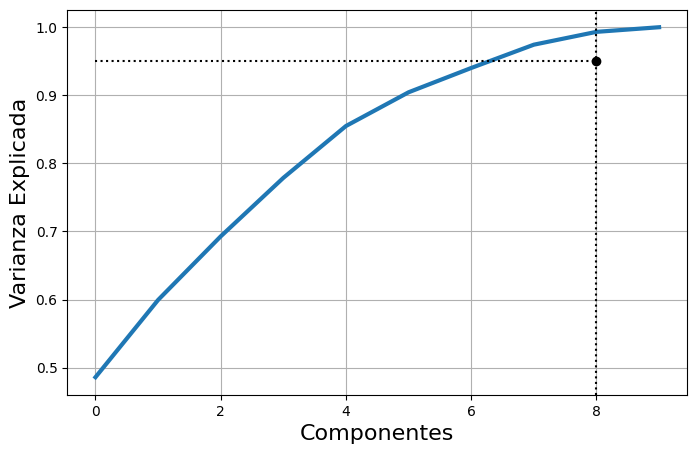

In [107]:

var_frac = 0.95


# Calcular la suma cumulativa y hacer su gráfica
cumsum = np.cumsum(pca_testeo.explained_variance_ratio_) 
# eso nos dice cuanta información es retenida si paramos en cada dimensión

# En qué momento la suma cumulativa llega a var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('Con {} componentes, preservamos el {} de la varianza.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Componentes", fontsize=16)
plt.ylabel("Varianza Explicada", fontsize=16)

plt.grid(True)


Text(0, 0.5, 'Explained Variance Ratio')

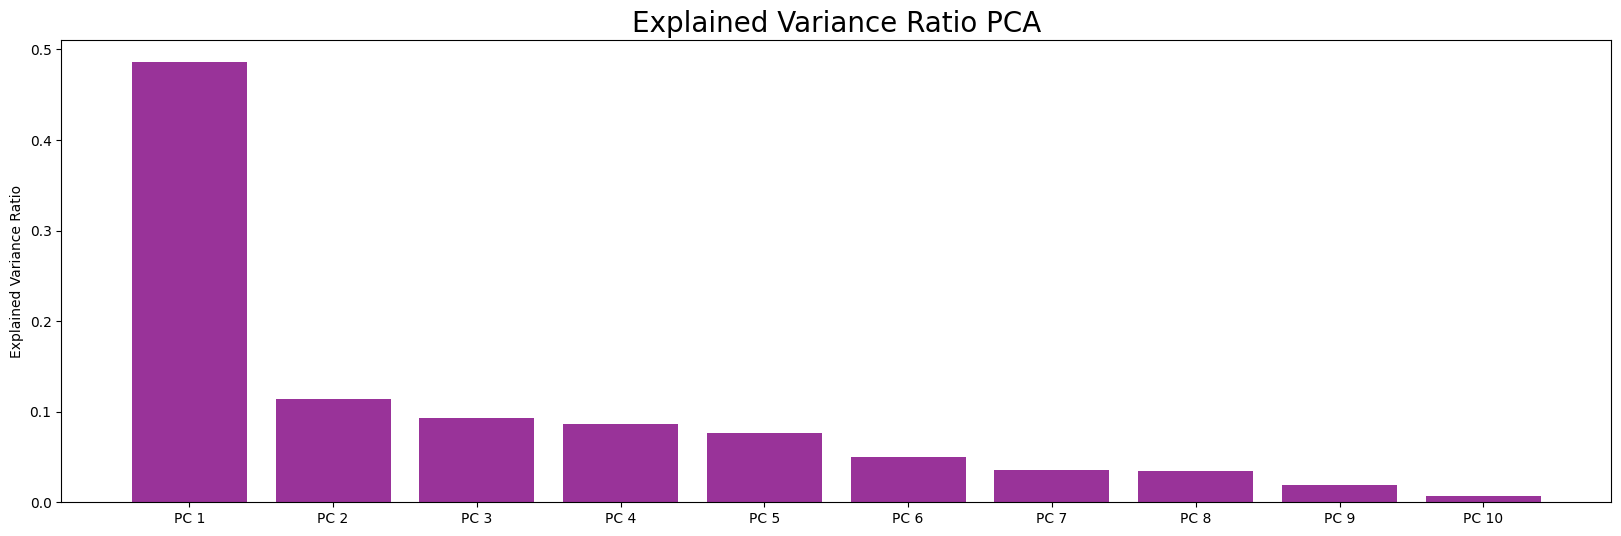

In [110]:
fig, ax = plt.subplots(ncols=1, figsize=(20,6))

ratio = pca_testeo.explained_variance_ratio_
ax.bar(range(len(ratio)), ratio, color='purple', alpha=0.8)
ax.set_title('Explained Variance Ratio PCA', fontsize=20)
ax.set_xticks(range(len(ratio)))
ax.set_xticklabels(['PC {}'.format(i+1) for i in range(len(ratio))])
ax.set_ylabel('Explained Variance Ratio')

In [115]:
pca_testeo = PCA(7).fit(selected_variables_scaled)
X_pca_testeo = pca_testeo.transform(selected_variables_scaled)

In [112]:
y = tracks_selected.genre

In [117]:
from sklearn.model_selection import train_test_split
svs_train,svs_test,y1_train,y1_test = train_test_split(selected_variables_scaled,y,random_state=42,test_size=0.3)
Xpca_train,Xpca_test,y2_train,y2_test = train_test_split(X_pca_testeo,y,random_state=42,test_size=0.3)

In [118]:
reg1 = LogisticRegression()
reg2 = LogisticRegression()

reg1.fit(svs_train,y1_train)
reg2.fit(Xpca_train,y2_train)



LogisticRegression()

In [119]:
y1_pred=reg1.predict(svs_test)
y2_pred=reg2.predict(Xpca_test)

In [120]:
from sklearn.metrics import accuracy_score

acc1 = accuracy_score(y1_test,y1_pred)
acc2 = accuracy_score(y2_test,y2_pred)
print(acc1,acc2)

0.7402190923317684 0.7276995305164319


Probar de meter las variables categoricas en los modelos, probar pca contra randomforest, terminar el todo junto, ver bien las metricas y terminar el ppt.